# **Sentiment Analysis using LSTM Model**
Using keras library for LSTM on Tensorflow backend    
sklearn for confusion matrix  
NLTK for pre-processing  
matplotlib for plots

In [1]:
import pandas as pd
import numpy as np
import re, string, unicodedata
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import h5py
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


from keras.models import Model, Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


Using TensorFlow backend.


## Set constants

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 3000
EMBEDDING_DIM = 160

## Read Dataset

In [3]:
train_df = pd.read_csv('gs://stanforddrugreviews/drugsComTrain_raw.tsv', sep='\t')
test_df = pd.read_csv('gs://stanforddrugreviews/drugsComTest_raw.tsv', sep='\t')

## Add labels to dataset

In [4]:
def rank_bin(array):
  y_rank = []
  for i in array:
    if i <= 4: # Negative Rating Cut Off (Inclusive)
      y_rank.append('Negative')
    elif i >= 7: # Positive Rating Cut Off (Inclusive)
      y_rank.append('Positive')
    else:
      y_rank.append('Neutral')
  return y_rank

# Assign test & train data their classes.
train_df['classes_to_predict'] = rank_bin(train_df['rating'])
test_df['classes_to_predict'] = rank_bin(test_df['rating'])

# Make a variable to contain the class labels.
classes_to_predict = ['Positive','Negative','Neutral']
print(train_df['classes_to_predict'].value_counts())
print(test_df['classes_to_predict'].value_counts()) # Check to see the bin sizes.

Positive    106866
Negative     40075
Neutral      14356
Name: classes_to_predict, dtype: int64
Positive    35440
Negative    13497
Neutral      4829
Name: classes_to_predict, dtype: int64


## Define Text Pre-process functions

In [5]:
# Regex for removing non-alphanumeric characters and spaces
remove_special_char = re.compile('r[^a-z\d]',re.IGNORECASE)

# Regex to replace all numerics
replace_numerics = re.compile(r'\d+',re.IGNORECASE)

# F&#K Unicode Emojis
emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)

# Load NLTK stop words
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
print ("NLTK stopword list length: ",len(stop_words),'words')

# Add custom drug stopwords
#stop_words.extend(drug_stopwords)
#print ("Added custom stopwords")
#print ("New stopword list length: ",len(stop_words),'words')



#######################################################
#NORMALIZER, RUNS IN PREPROCESS
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', unicode(word, errors='ignore')).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words


# Define Text-PreProcessing function
#################################################################
def preprocess_text(text, remove_stopwords = True, perform_stemming = True):
    #first clean text then go to lowercase and split.
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"(\d)", "")
    text = text.replace(r"@\S+", "")
    text = text.replace(r"@", "at")
    text = remove_special_char.sub('', text)
    text = replace_numerics.sub('n', text)
    text = emoji_pattern.sub('', text)
    text = text.replace( r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)","")
    text = text.replace( r"(\-)|(\\)|(\s{2,})"," ")
    text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    text = text.replace(r"(&#n;)", "")
    
    # per/wordprocessing
    textlist = text.lower().split()
    textlist = normalize(textlist)
    text = ' '.join(textlist) 
    #stopword removal (nltk + custom drug stopwords)
#    if(remove_stopwords):
#        textlist = [word for word in textlist if word not in stop_words]
  
    # stemming  
    if(perform_stemming):
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = ' '.join(stemmed_words)
        
    return text

('NLTK stopword list length: ', 179, 'words')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Pre-process reviews and vectorize y

In [6]:
# Clean text
raw_train_comments = train_df['review'].fillna('NA').values
raw_test_comments = test_df['review'].fillna('NA').values

# Define y for Training/Validation 
y = pd.get_dummies(train_df['classes_to_predict']).values

# Define y for Tests
y_test_predicted = pd.get_dummies(test_df['classes_to_predict']).values


# Process reviews for Training (X)
processed_train_comments = []
for comment in raw_train_comments:
    processed_train_comments.append(preprocess_text(comment))

# Process reviews for Testing (X)
processed_test_comments = []    
for comment in raw_test_comments:
    processed_test_comments.append(preprocess_text(comment))

In [7]:
processed_test_comments[0:5]

[u'inv tri antidepress oveth year citalopram fluoxetin amitriptylin none help depress insomnia amp anxieti doctosuggest chang onto nmg mirtazapin medicin save life thank side effect especi common weight gain inv actual lost alot weight still suicid thought mirtazapin save',
 u'son crohnn diseas done well asacol complaint show side effect taken mani nine tablet peday one time inv happi result reduc bout diarrhea drastic',
 u'quick reduct symptom',
 u'contrav combin drug use foalcohol smoke opioid cessat peopl lose weight also help control oveeat doubt obes caus sugacarb addict power drug take fofiv day good news seem go work immedi feel hungri want food realli donnt care eat itn fill stomach sinc day donnt know inv lost weight donnt scale cloth feel littl loos mayb pound otwo inm hope aftea month medic develop healthiehabit continu without aid contrav',
 u'birth control foon cycl afteread review type similabirth control bit apprehens start im give birth control n n long enough foa n fai

In [8]:
y[0:5]

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [9]:
train_df_iq = pd.DataFrame(y)
train_df_iq[3] = processed_train_comments

In [10]:
len(train_df_iq)

161297

In [11]:
train_df_iq[0:2]

,0,1,2,3
0,0,0,1,side effect take combin bystol n mg fish oil
1,0,0,1,son halfway fourth week intuniv becam concern ...


In [12]:
train_df_iq["strlen"] = train_df_iq[3].str.split().str.len()

## Remove outliers from dataset

In [13]:
train_df_iq = train_df_iq.loc[train_df_iq["strlen"] <= MAX_SEQUENCE_LENGTH]

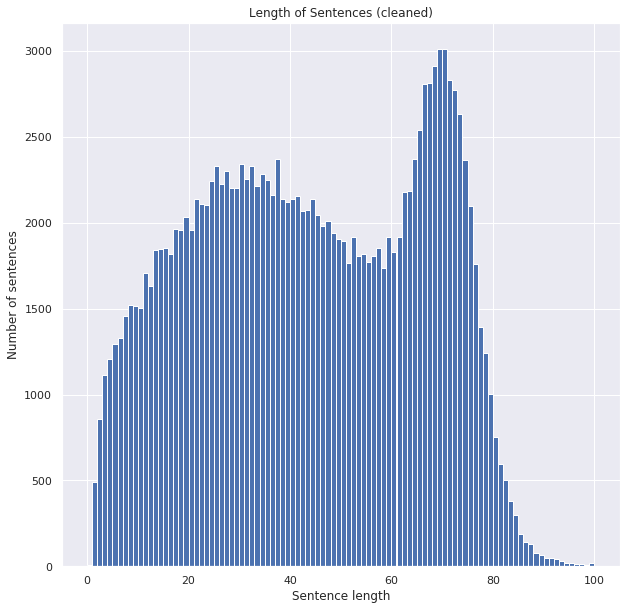

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Sentences (cleaned)')
plt.hist(train_df_iq["strlen"], bins=MAX_SEQUENCE_LENGTH)
plt.show()

In [15]:
post_processed_train_comments = train_df_iq[3].tolist()
post_processed_y = train_df_iq[[0, 1, 2]].values

## Tokenize reviews and create vector sequences

In [16]:
# Tokenize the data
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False, 
                      oov_token=None, document_count=0)

tokenizer.fit_on_texts(post_processed_train_comments + processed_test_comments)

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(post_processed_train_comments)
test_sequences = tokenizer.texts_to_sequences(processed_test_comments)
word_index = tokenizer.word_index
print('found %s tokens in text.' %(len(word_index)))

# Ensure all sequences have the same length. 
train_data = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)
final_test_data = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH)

# Print shapes of data. 

print(train_data.shape, '<-- shape of train_data ready for val/train split.')
print(final_test_data.shape, '<-- shape of final_test_data ready for feeding to network.')
print(len(word_index), '<-- Length of Word Index')

((161033, 100), '<-- shape of train_data ready for val/train split.')
((53766, 100), '<-- shape of final_test_data ready for feeding to network.')
(113282, '<-- Length of Word Index')


## Split training dataset into train and validation set

In [17]:
# Split Training & Validation Data
print('creating train and validation data by dividing train_data in 80:20 ratio')

X_train, X_val, Y_train, Y_val = train_test_split(train_data, post_processed_y,
                                                  test_size = 0.2,  stratify= post_processed_y, 
                                                  random_state = 2018)
X_test = final_test_data
Y_test = y_test_predicted

creating train and validation data by dividing train_data in 80:20 ratio


## Configure LSTM model

In [18]:
nb_words  = min(MAX_NB_WORDS, len(word_index))
lstm_out = MAX_SEQUENCE_LENGTH

model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(50))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 160)          480000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                42200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 522,353
Trainable params: 522,353
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [20]:
title = 'Drug_Data_LSTM_w_stopwords_1.0_'
training_cycle = 1
batch = 32 

stamp = '{}training_cycle_{}_batchsize_{}'.format(title,training_cycle,batch)
print(stamp)
best_model_path = title + stamp + 'best.h5'

early_stopping = EarlyStopping(patience = 4)
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only = True)


# Run LSTM Model
epoch = 40
LSTM_model = model.fit(X_train, Y_train, batch_size=batch, epochs=epoch,
                       validation_data=(X_val, Y_val), shuffle = True, 
                       callbacks = [early_stopping, model_checkpoint], verbose = 0)
best_score = min(LSTM_model.history['val_loss'])

Drug_Data_LSTM_w_stopwords_1.0_training_cycle_1_batchsize_32
Instructions for updating:
Use tf.cast instead.


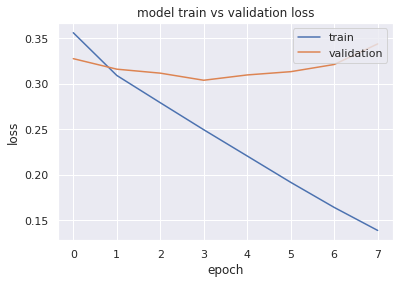

In [21]:
# Plot training vs validation loss over epoch. 

plt.plot(LSTM_model.history['loss'])
plt.plot(LSTM_model.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

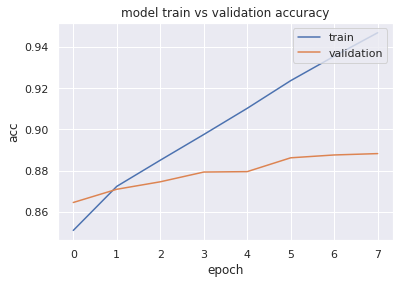

In [22]:
plt.plot(LSTM_model.history['acc'])
plt.plot(LSTM_model.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
accr = model.evaluate(X_test,Y_test, batch_size = 256)

53766/53766 [==============================] - 31s 571us/step


In [24]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.346
  Accuracy: 0.888


## Predict y on test dataset

In [26]:
prediction = model.predict(X_test)

## Print Confusion Matrix and Error rates

In [27]:
target_names = ['Positive','Neutral','Negative']
print(confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1)))

[[10650   821  2026]
 [ 1323  1787  1719]
 [ 2233  1073 32134]]


In [28]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    #plt.ylabel('True label', fontsize=30)
    #plt.xlabel('Predicted label', fontsize=30)

    return plt

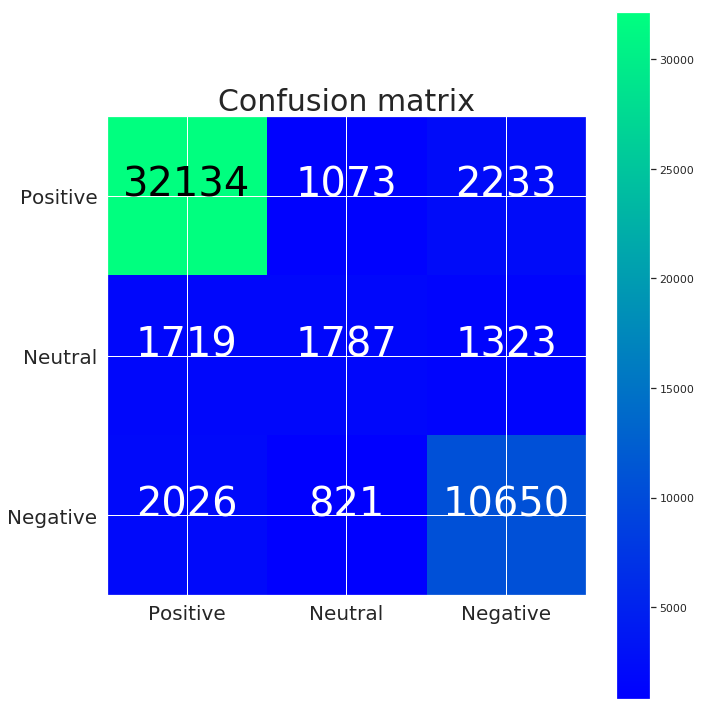

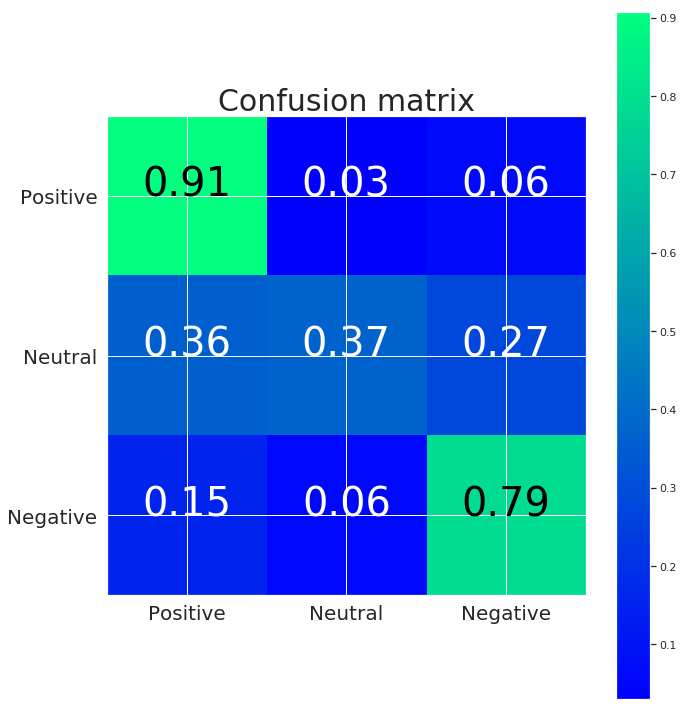

In [29]:
cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [2,1,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()

cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [2,1,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Neutral','Negative'], normalize=True, title='Confusion matrix')
plt.show()